# Random selection

### Plain English summary
Don't have a machine learning model, instead allocate a random class and look at teh performance of this,

### Model and data

### Aims

### Observations


## Import libraries

In [25]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

import json

from dataclasses import dataclass

import seaborn as sns

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix

## Set up paths and filenames

In [26]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

  #  data_path: str = '../'
  #  data_filename: str = 'SAMueL ssnap extract v2.csv'
    data_save_path: str = './'
  #  data_save_filename: str = 'reformatted_data.csv'
  #  database_filename: str = 'samuel.db'
  #  notebook: str = '01'
  #  kfold_folder: str = 'data/kfold_5fold/'

    data_read_path: str = '../data/kfold_5fold'
#    data_read_filename: str = '03_reformatted_data_ml.csv'
 #   data_save_path: str = './kfold_5fold'
#    data_save_filename: str = 'train.csv'
    notebook: str = '01a_'

paths = Paths()

## Import data

Data has previously been split into 5 stratified k-fold splits.

In [27]:
train_data, test_data = [], []

for i in range(5):
    
    train_data.append(pd.read_csv(paths.data_read_path + '/03_train_{0}.csv'.format(i)))
    test_data.append(pd.read_csv(paths.data_read_path + '/03_test_{0}.csv'.format(i)))

Get list of features

In [28]:
features = list(train_data[0])
print(f"There are {len(features)} features")

There are 51 features


## One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [29]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    df [dataframe]: training or test dataset
    feature_name [str]: feature to convert to ont hot encoding
    prefix [str]: string to use on new feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [30]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, for each train and test dataset, convert to one hot encoded.

In [31]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    for k_fold in range(5):
        train_data[k_fold] = convert_feature_to_one_hot(train_data[k_fold], feature, prefix)
        test_data[k_fold] = convert_feature_to_one_hot(test_data[k_fold], feature, prefix)

Each train and test set not necessarily have all columns.
Check if each train and test dataset contains each category.

In [32]:
set_one_hot_features = set()
for k_fold in range(5):
    temp_set = set(train_data[k_fold].columns).union(set(test_data[k_fold].columns))
    set_one_hot_features = set_one_hot_features.union(temp_set)

Print if any columns are missing.

In [33]:
for k_fold in range(5):
    if len(list(set_one_hot_features - set(train_data[k_fold].columns))) > 0:
        print(f"Train kfold {k_fold}: {set_one_hot_features - set(train_data[k_fold].columns)}")
    if len(list(set_one_hot_features - set(test_data[k_fold].columns))) > 0:
        print(f"Test kfold {k_fold}: {set_one_hot_features - set(test_data[k_fold].columns)}")

## Randomly allocate classification for each instance.

In [34]:
r_square_kfold = []

k_fold = 0

# Get k fold split
train = train_data[k_fold]
test = test_data[k_fold]

# Get X and y
X_train = train.drop('discharge_disability', axis=1)
X_test = test.drop('discharge_disability', axis=1)
y_train = train['discharge_disability']
y_test = test['discharge_disability']

n_categories = y_test.nunique()
n_instances = y_test.shape[0]

# Randomly create predicted probabilities
y_probs = np.empty((n_instances,n_categories), dtype=object)
for i in range(n_instances):
    temp_array = np.random.randint(low=0, high=100, size=n_categories)
    temp_array = temp_array/temp_array.sum()
    y_probs[i,:] = temp_array

# Observation from the probability
# Use random integers ofor orginal
y_pred = np.argmax(y_probs, axis=1)#observed = np.random.randint(low=0, high=n_categories, size=n_instances)

# Calculate error
y_error = y_test - y_pred

Show accuracy (identity)

In [35]:
accuracy = np.mean(y_error==0)
print (f'Accuracy: {accuracy:0.2f}')

error_within_one = np.mean(np.abs(y_error)<=1)
print (f'Error within 1: {error_within_one:0.2f}')

Accuracy: 0.14
Error within 1: 0.39


Show descriptive statistics of error

In [36]:
# Show descriptive statistics of error
pd.Series(y_error).describe().round(2)

count    15363.00
mean        -0.29
std          2.77
min         -6.00
25%         -2.00
50%          0.00
75%          2.00
max          6.00
Name: discharge_disability, dtype: float64

Show descriptive statistics of absolute error

In [37]:
pd.Series(np.abs(y_error)).describe().round(2)

count    15363.00
mean         2.25
std          1.65
min          0.00
25%          1.00
50%          2.00
75%          3.00
max          6.00
Name: discharge_disability, dtype: float64

Show regression analysis

In [38]:
# Fit a regression line to the points
slope, intercept, r_value, p_value, std_err = \
    scipy.stats.linregress(y_pred, y_test)
r_square = r_value ** 2
r_square_kfold.append(r_square)
y_reg_pred = intercept + (y_test * slope)

print (f'Intercept: {intercept:0.2f}')
print (f'Slope: {slope:0.2f}')
print (f'R-squared: {r_square:0.3f}')
print (f'P-value: {p_value:0.4f}')

Intercept: 2.68
Slope: -0.01
R-squared: 0.000
P-value: 0.1335


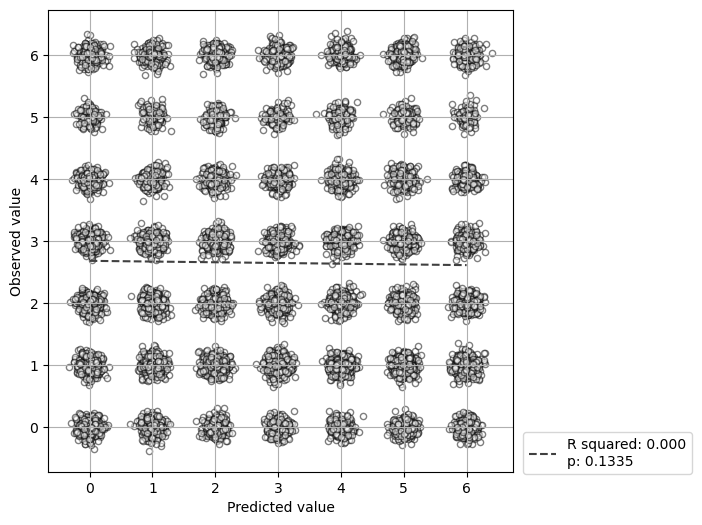

In [39]:
# Add jitter to points for plotting (clip to avoid overlap)
size = len(y_test)
jitter = np.random.normal(loc=0, scale=0.1, size=size).clip(-0.45, 0.45)
x = y_pred + jitter
jitter = np.random.normal(loc=0, scale=0.1, size=size).clip(-0.45, 0.45)
y = y_test + jitter

# Calculate regression line
x_regression = np.arange(0, 7)
y_regression = (x_regression * slope) + intercept

fig = plt.figure(figsize=(6,6))
text = f'R squared: {r_square:.3f}\np: {p_value:0.4f}'
ax1 = fig.add_subplot(111)
ax1.scatter(x, y, edgecolors='black', facecolor='w', alpha=0.5, marker='o', s=20)
ax1.plot(x_regression, y_regression, '--', color='0.25', label=text)
ax1.legend(loc='best', bbox_to_anchor=(0.9, -0.4, 0.5, 0.5))
ax1.grid()
ax1.set_xlabel('Predicted value')
ax1.set_ylabel('Observed value')
plt.show()

# Represent data density with circle size

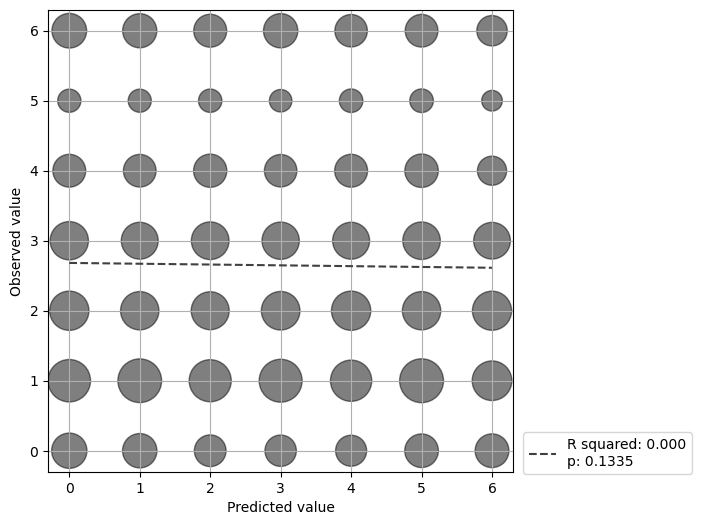

In [40]:
# Create dataframe with two columns (observed and predicted)
data = {"observed": y_pred, "predicted": y_test}
df_obs_pred = pd.DataFrame(data)

# Calculate frequency of each confusion matrix entry, as proportion of maximum frequency
count_categories = df_obs_pred.groupby(["observed", "predicted"]).size()
count_categories = count_categories/count_categories.max()

# Create two lists for the available categories
list_y_pred = []
list_y_test = []
for i in range(count_categories.index.shape[0]):
    list_y_pred.append(count_categories.index[i][0])
    list_y_test.append(count_categories.index[i][1])

# Calculate regression line
x_regression = np.arange(0, 7)
y_regression = (x_regression * slope) + intercept

# Scatter plot and regression line
fig = plt.figure(figsize=(6,6))
text = f'R squared: {r_square:.3f}\np: {p_value:0.4f}'
ax1 = fig.add_subplot(111)
ax1.scatter(list_y_pred, list_y_test, edgecolors='black', facecolor='black', alpha=0.5, 
            marker='o', s=count_categories.values*1000)
ax1.plot(x_regression, y_regression, '--', color='0.25', label=text)
ax1.legend(loc='best', bbox_to_anchor=(0.9, -0.4, 0.5, 0.5))
ax1.grid()
ax1.set_xlabel('Predicted value')
ax1.set_ylabel('Observed value')
plt.show()

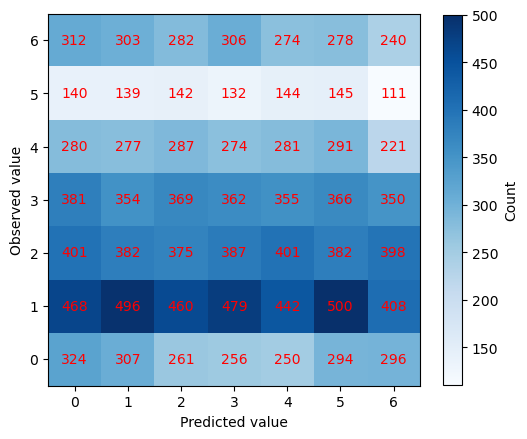

In [50]:
# Show confusion matrix
cm = confusion_matrix(y_test, y_pred)

origin='lower'

# Visualize the confusion matrix with colors
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(1,1,1)
heatmap = plt.imshow(cm, cmap=plt.cm.Blues, origin=origin)
colorbar = plt.colorbar(heatmap, shrink=0.8, ax=ax1, alpha=0.5, label='Count')

# To add values to plot
for i in range(len(cm)):
    for j in range(len(cm[0])):
        if origin=='lower':
            plt.text(j, i, cm[i][j], ha='center', va='center', color='r')
        else:            
            plt.text(i, j, cm[i][j], ha='center', va='center', color='r')

ax1.set_xlabel('Predicted value')
ax1.set_ylabel('Observed value')
plt.show()

## Convert to binary outcome
Set "Outcome" to 0 for mRS 0-2 (to represent good).
Set "Outcome" to 1 for mRS 3-6 (to represent bad).

In [42]:
# Convert from 0-6 to binary
binary_outcome: dict = {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1}
y_test_binary = (pd.Series(y_test).map(binary_outcome))
y_pred_binary = (pd.Series(y_pred).map(binary_outcome))
y_error_binary = y_test_binary - y_pred_binary
accuracy = np.mean(y_error_binary==0)
print (f'Accuracy: {accuracy:0.2f}')

Accuracy: 0.49


In [43]:
# Get ROC AUC
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_binary)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.4972293261081083


In [44]:
# Get ROC AUC
#    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
#    roc_auc = auc(fpr, tpr)
#    feature_auc_kfold.append(roc_auc)

# Get average result from all k-fold splits
#feature_auc_mean = np.mean(feature_auc_kfold)

# Get average result from all k-fold splits
r_square_mean = np.mean(r_square_kfold)

print (f'All features, regression {r_square_mean:0.3f} '
    f'(std across 5 kfolds: {np.std(r_square_kfold):0.3f})')

All features, regression 0.000 (std across 5 kfolds: 0.000)


In [45]:
# Count occurance of each error
value_counts = y_error.value_counts()

# Calculate proportion correct (number of zero errors, by total number instances)
accuracy = value_counts.iloc[0]/value_counts.sum()

accuracy

0.14469830111306387

## Multiclass ROC AUC

https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a

https://github.com/vinyluis/Articles/blob/main/ROC%20Curve%20and%20ROC%20AUC/ROC%20Curve%20-%20Multiclass.ipynb


Functions are slightly modified from the binary classifier case

In [46]:

def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

In [47]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [48]:
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

### ROC Curve - One vs Rest (OvR)

Compares each class with the rest of the classes

In [ ]:
classes = y_test.unique()
classes = np.sort(classes)

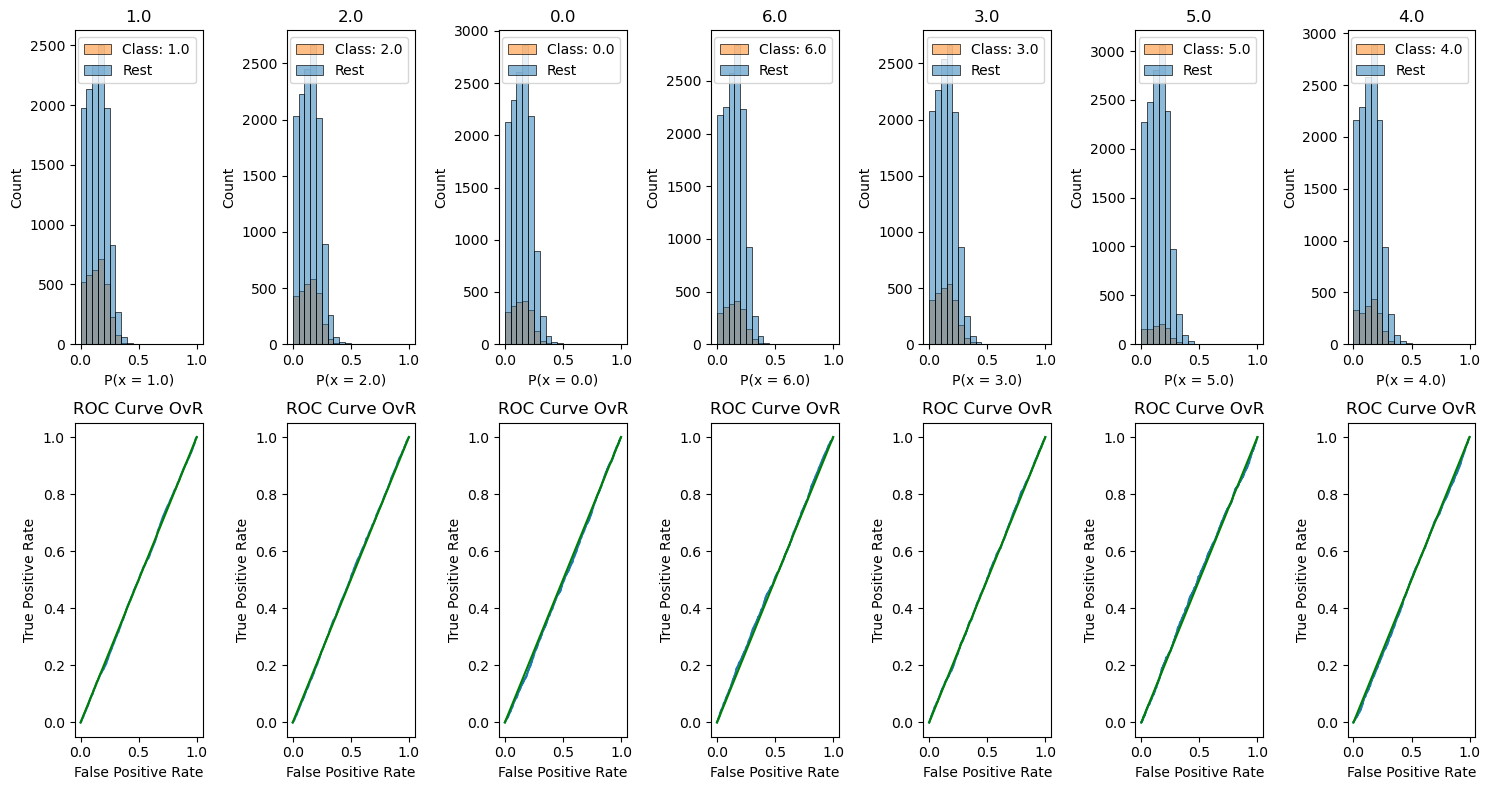

In [52]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (15, 8))
bins = [i/20 for i in range(20)] + [1]
#classes = list(set(observed))#model.classes_
roc_auc_ovr = {}

for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = pd.DataFrame() #df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_probs[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, len(classes), i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, len(classes), i+len(classes)+1)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()

In [53]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovr:
    avg_roc_auc += roc_auc_ovr[k]
    i += 1
    print(f"{k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
print(f"average ROC AUC OvR: {avg_roc_auc/i:.4f}")

1.0 ROC AUC OvR: 0.4991
2.0 ROC AUC OvR: 0.5024
0.0 ROC AUC OvR: 0.4915
6.0 ROC AUC OvR: 0.5086
3.0 ROC AUC OvR: 0.5024
5.0 ROC AUC OvR: 0.5041
4.0 ROC AUC OvR: 0.4927
average ROC AUC OvR: 0.5001


In [69]:
# Compares with sklearn (average only)
# "Macro" average = unweighted mean
roc_auc_score(y_test, y_probs, labels = classes, multi_class = 'ovr', average = 'macro')

0.500852110688913

### ROC Curve - One vs One (OvO)
Compares each possible combination of the classes, two at a time

In [70]:
classes_combinations = []
class_list = list(classes)
for i in range(len(class_list)):
    for j in range(len(class_list)):
        if i != j:
            classes_combinations.append([class_list[i], class_list[j]])
classes_combinations

[[0.0, 1.0],
 [0.0, 2.0],
 [0.0, 3.0],
 [0.0, 4.0],
 [0.0, 5.0],
 [0.0, 6.0],
 [1.0, 0.0],
 [1.0, 2.0],
 [1.0, 3.0],
 [1.0, 4.0],
 [1.0, 5.0],
 [1.0, 6.0],
 [2.0, 0.0],
 [2.0, 1.0],
 [2.0, 3.0],
 [2.0, 4.0],
 [2.0, 5.0],
 [2.0, 6.0],
 [3.0, 0.0],
 [3.0, 1.0],
 [3.0, 2.0],
 [3.0, 4.0],
 [3.0, 5.0],
 [3.0, 6.0],
 [4.0, 0.0],
 [4.0, 1.0],
 [4.0, 2.0],
 [4.0, 3.0],
 [4.0, 5.0],
 [4.0, 6.0],
 [5.0, 0.0],
 [5.0, 1.0],
 [5.0, 2.0],
 [5.0, 3.0],
 [5.0, 4.0],
 [5.0, 6.0],
 [6.0, 0.0],
 [6.0, 1.0],
 [6.0, 2.0],
 [6.0, 3.0],
 [6.0, 4.0],
 [6.0, 5.0]]

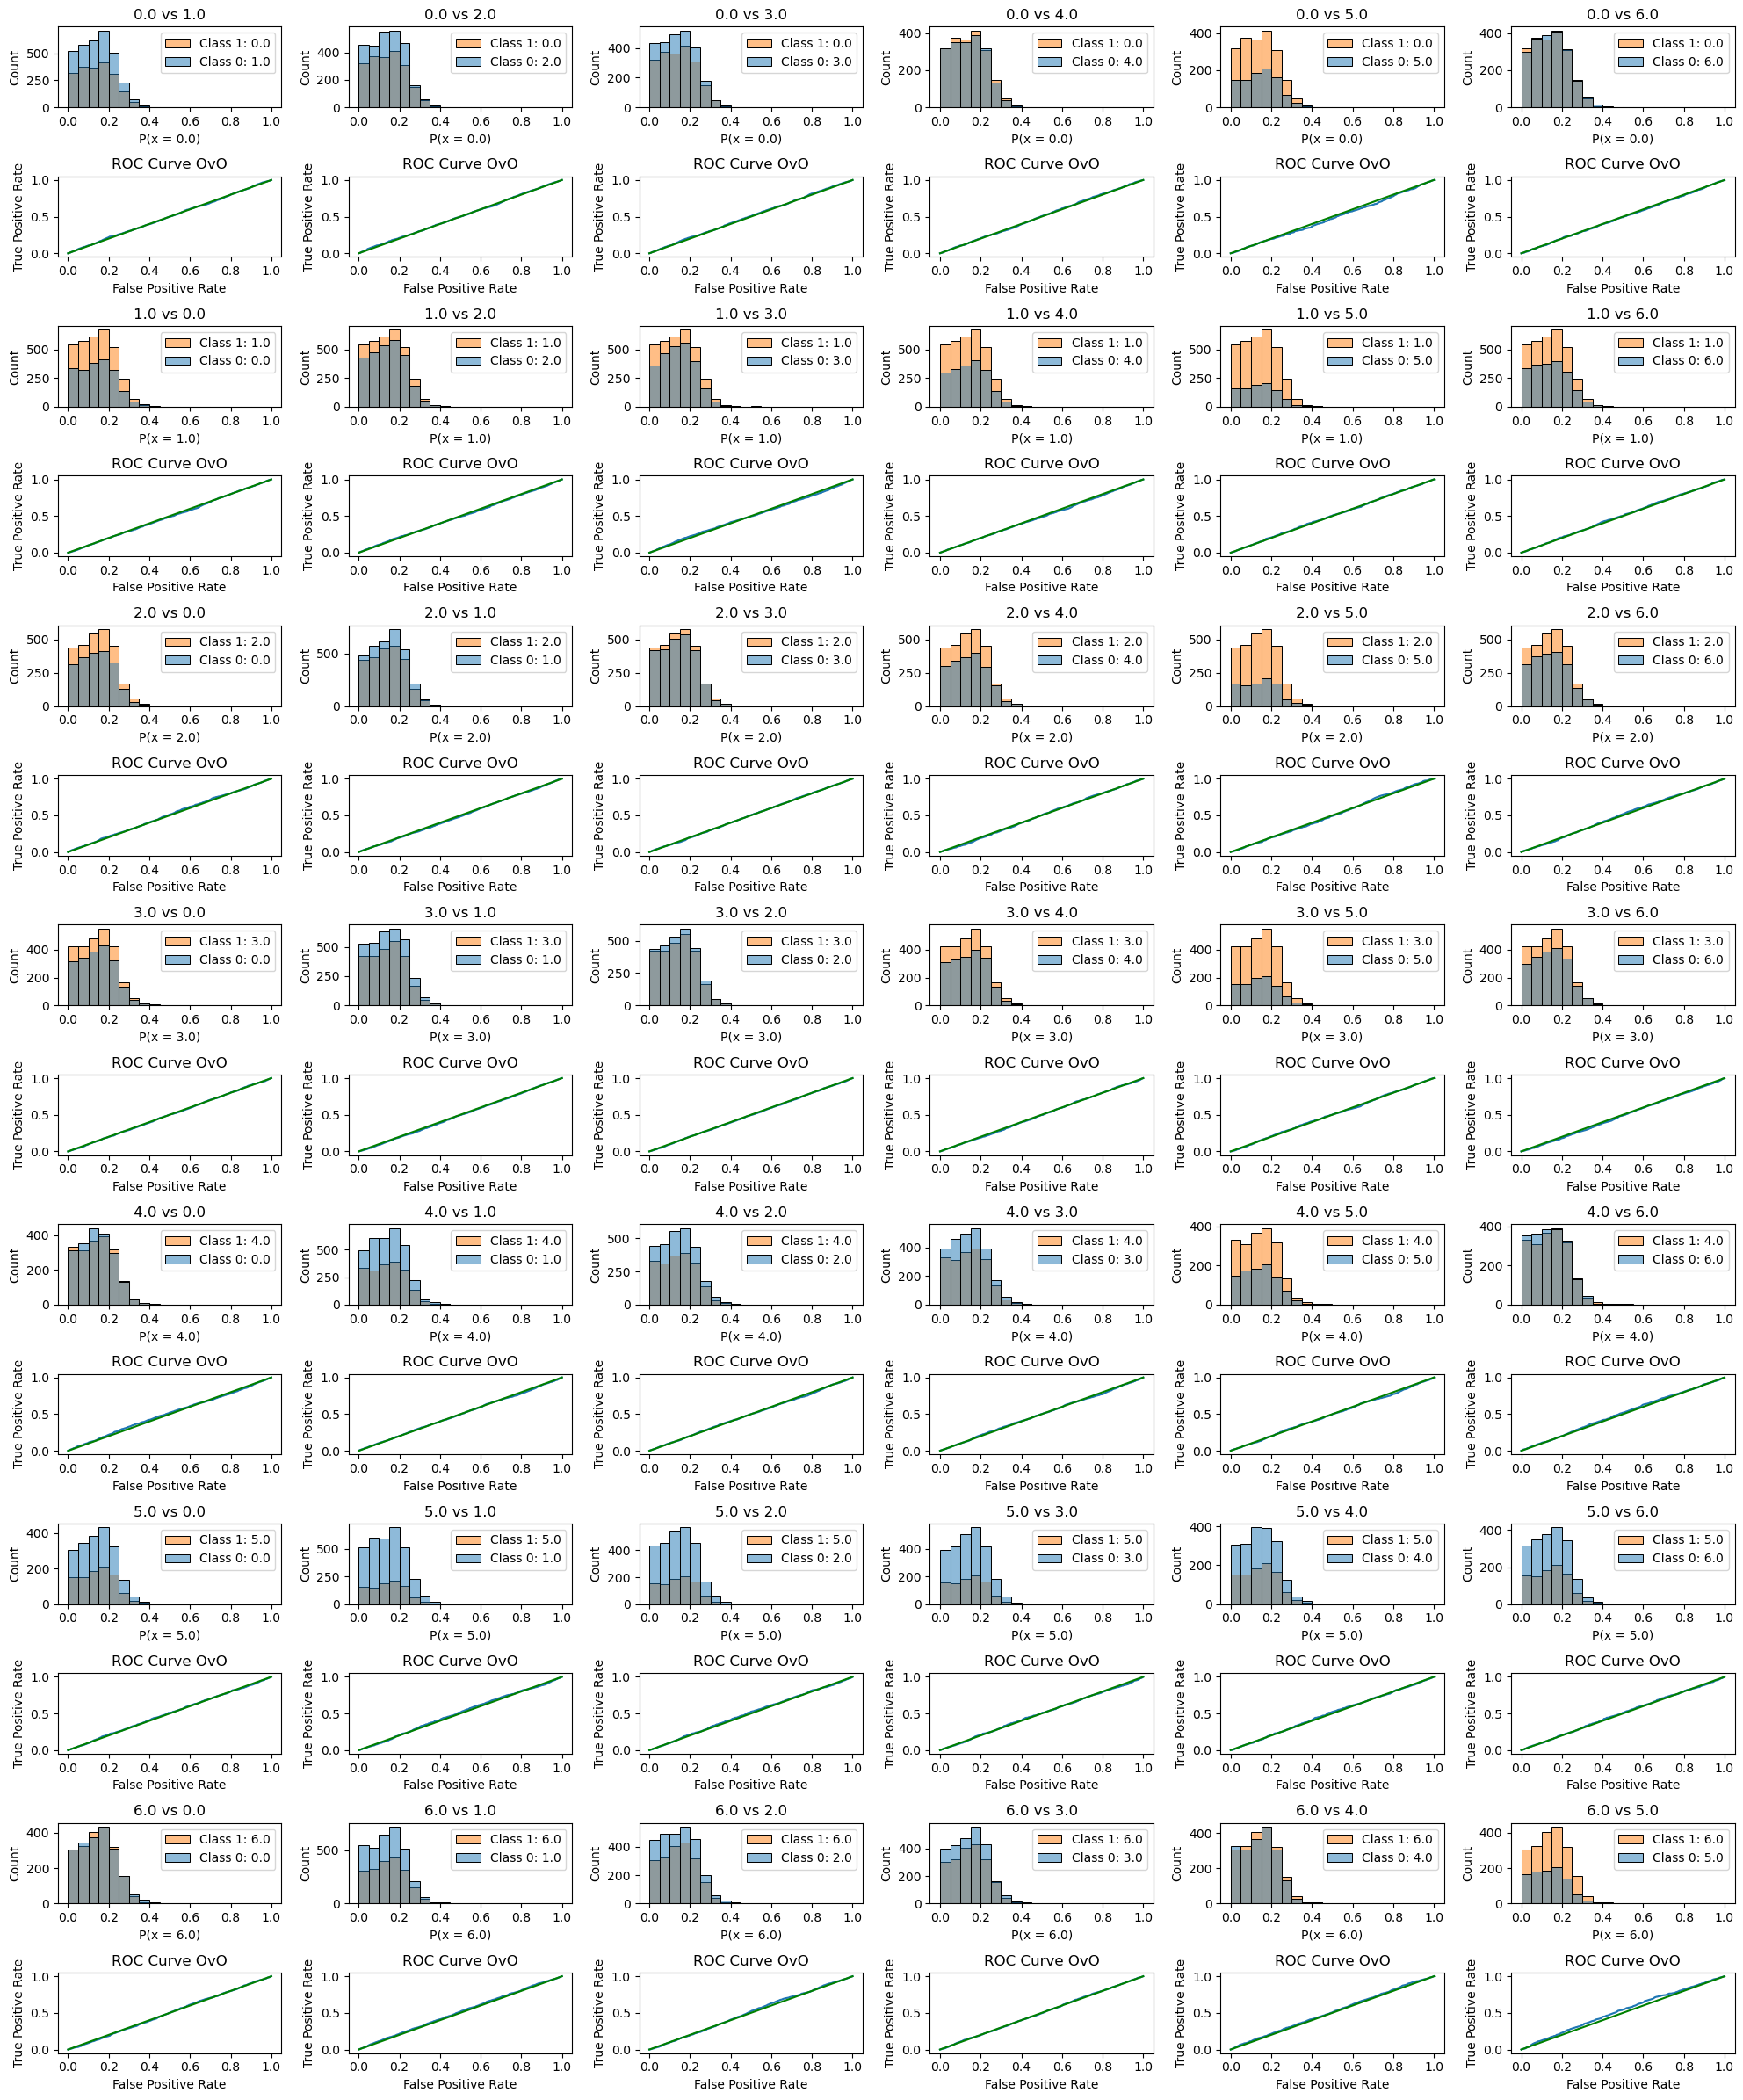

In [77]:
# Plots the Probability Distributions and the ROC Curves One vs ONe

fig_height = 4 * (n_categories-1)

plt.figure(figsize = (20, fig_height))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovo = {}

# For subplot placement
col_top = 0
group_count = 0

for i in range(len(classes_combinations)):
    
    # Gets the class
    comb = classes_combinations[i]
    c1 = comb[0]
    c2 = comb[1]
    c1_index = class_list.index(c1)
    title = str(c1) + " vs " + str(c2)
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = pd.DataFrame()#X_test.copy()
    df_aux['class'] = y_test
    df_aux['prob'] = y_probs[:, c1_index]
    
    # Slices only the subset with both classes
    df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]
    df_aux['class'] = [1 if y == c1 else 0 for y in df_aux['class']]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    group_count += 1
    col_top += 1
    if group_count == (n_categories):
        group_count = 1
        col_top = col_top + (n_categories-1)

    ax = plt.subplot(2*n_categories, n_categories-1, col_top)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(title)
    ax.legend([f"Class 1: {c1}", f"Class 0: {c2}"])
    ax.set_xlabel(f"P(x = {c1})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    col_bottom = col_top + (n_categories-1)
    ax_bottom = plt.subplot(2*n_categories, n_categories-1, col_bottom)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvO")
    
    # Calculates the ROC AUC OvO
    roc_auc_ovo[title] = roc_auc_score(df_aux['class'], df_aux['prob'])
    
plt.tight_layout()

In [72]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovo:
    avg_roc_auc += roc_auc_ovo[k]
    i += 1
    print(f"{k} ROC AUC OvO: {roc_auc_ovo[k]:.4f}")
print(f"average ROC AUC OvO: {avg_roc_auc/i:.4f}")

0.0 vs 1.0 ROC AUC OvO: 0.5010
0.0 vs 2.0 ROC AUC OvO: 0.5027
0.0 vs 3.0 ROC AUC OvO: 0.5070
0.0 vs 4.0 ROC AUC OvO: 0.5031
0.0 vs 5.0 ROC AUC OvO: 0.4825
0.0 vs 6.0 ROC AUC OvO: 0.4946
1.0 vs 0.0 ROC AUC OvO: 0.4939
1.0 vs 2.0 ROC AUC OvO: 0.4964
1.0 vs 3.0 ROC AUC OvO: 0.4987
1.0 vs 4.0 ROC AUC OvO: 0.4920
1.0 vs 5.0 ROC AUC OvO: 0.5027
1.0 vs 6.0 ROC AUC OvO: 0.5061
2.0 vs 0.0 ROC AUC OvO: 0.5074
2.0 vs 1.0 ROC AUC OvO: 0.4932
2.0 vs 3.0 ROC AUC OvO: 0.5002
2.0 vs 4.0 ROC AUC OvO: 0.4978
2.0 vs 5.0 ROC AUC OvO: 0.5002
2.0 vs 6.0 ROC AUC OvO: 0.5042
3.0 vs 0.0 ROC AUC OvO: 0.4974
3.0 vs 1.0 ROC AUC OvO: 0.4928
3.0 vs 2.0 ROC AUC OvO: 0.4959
3.0 vs 4.0 ROC AUC OvO: 0.4958
3.0 vs 5.0 ROC AUC OvO: 0.5005
3.0 vs 6.0 ROC AUC OvO: 0.4878
4.0 vs 0.0 ROC AUC OvO: 0.5074
4.0 vs 1.0 ROC AUC OvO: 0.4976
4.0 vs 2.0 ROC AUC OvO: 0.4974
4.0 vs 3.0 ROC AUC OvO: 0.4989
4.0 vs 5.0 ROC AUC OvO: 0.4943
4.0 vs 6.0 ROC AUC OvO: 0.5106
5.0 vs 0.0 ROC AUC OvO: 0.5027
5.0 vs 1.0 ROC AUC OvO: 0.5068
5.0 vs 2

In [73]:
n_categories = len(class_list)

roc_auc_ovo_array = np.empty((n_categories,n_categories), dtype=object)

# Displays the ROC AUC for each class
for k in roc_auc_ovo:
    roc_auc_ovo_array[int(k[0]),int(k[-3])] = roc_auc_ovo[k]

# No entry for diagonal, fill with zero
np.fill_diagonal(roc_auc_ovo_array, 0)

# Convert to flaot
roc_auc_ovo_array = roc_auc_ovo_array.astype(float)

Show the ROC AUC for the OvO as a heat map.

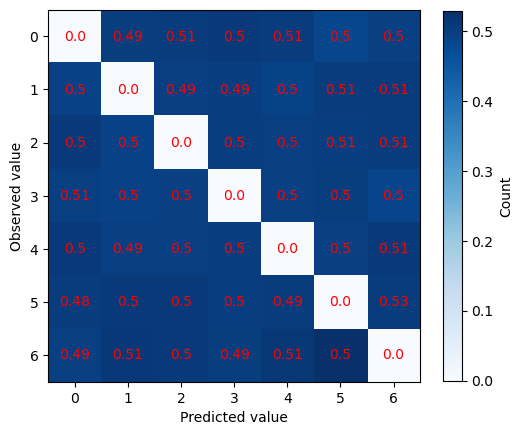

In [76]:
# Visualize the confusion matrix with colors
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(1,1,1)
heatmap = plt.imshow(roc_auc_ovo_array, cmap=plt.cm.Blues)
colorbar = plt.colorbar(heatmap, shrink=0.8, ax=ax1, alpha=0.5, label='Count')

# To add values to plot
for i in range(len(roc_auc_ovo_array)):
    for j in range(len(roc_auc_ovo_array[0])):
        plt.text(i, j, roc_auc_ovo_array[i][j].round(2), ha='center', va='center', color='r')

ax1.set_xlabel('Predicted value')
ax1.set_ylabel('Observed value')
plt.show()

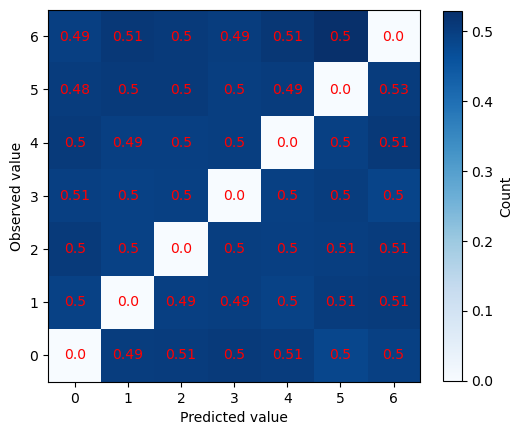

In [74]:
# Visualize the confusion matrix with colors
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(1,1,1)
heatmap = plt.imshow(roc_auc_ovo_array, cmap=plt.cm.Blues, origin='lower')
colorbar = plt.colorbar(heatmap, shrink=0.8, ax=ax1, alpha=0.5, label='Count')

# To add values to plot
for i in range(len(roc_auc_ovo_array)):
    for j in range(len(roc_auc_ovo_array[0])):
        plt.text(i, j, roc_auc_ovo_array[i][j].round(2), ha='center', va='center', color='r')

ax1.set_xlabel('Predicted value')
ax1.set_ylabel('Observed value')
plt.show()

In [75]:
# Compares with sklearn (average only)
# "Macro" average = unweighted mean
roc_auc_score(y_test, y_probs, labels = classes, multi_class = 'ovo', average = 'macro')

0.5010534136529315